In [1]:
import os 
import sys 
sys.path.append("../training")
import pickle
import copy
import time

import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, auc, roc_curve

# Local imports
from radius_labeler import RadiusLabeler
from threshold import ThresholdModel

In [2]:
NP_SEED = 0
np.random.seed(NP_SEED)

START_WINDOW = 0
END_WINDOW = 770
VAL_SPLIT = 0.3

DATA_OUT_DIR = f'../data/data_0_resplit'# 'qick_data/{START_WINDOW}_{END_WINDOW}'
MODEL_DIR = f'models/model_{START_WINDOW}_{END_WINDOW}'

# load data
X_tv = np.load(os.path.join(DATA_OUT_DIR, 'X_train.npy')).astype(np.float32)
X_test = np.load(os.path.join(DATA_OUT_DIR, 'X_test.npy')).astype(np.float32)  
y_tv = np.load(os.path.join(DATA_OUT_DIR, 'y_train.npy')).astype(np.float32)
y_test = np.load(os.path.join(DATA_OUT_DIR, 'y_test.npy')).astype(np.float32)

# Shuffle train-val
tv_shuffler = np.random.permutation(range(X_tv.shape[0]))
X_tv = X_tv[tv_shuffler]
y_tv = y_tv[tv_shuffler]

# Train-val split
X_train = X_tv[:int((1-VAL_SPLIT)*X_tv.shape[0])]
y_train = y_tv[:int((1-VAL_SPLIT)*X_tv.shape[0])]

X_val = X_tv[int((1-VAL_SPLIT)*X_tv.shape[0]):]
y_val = y_tv[int((1-VAL_SPLIT)*X_tv.shape[0]):]

assert(X_val.shape[0]+X_train.shape[0]==X_tv.shape[0])

In [3]:
X, y = copy.deepcopy(X_val), copy.deepcopy(y_val)

##################################### Centroid distance labeling #####################################
rad_labeler = RadiusLabeler()
rad_labeler.fit(X_train, y_train)
y_rad = rad_labeler.label(X, y)

##################################### Discriminating line labeling #####################################

thresholder = ThresholdModel()
thresholder.fit(X_train, y_train)
THETA_MUL = 0.94
THRESH_MUL = 1.2 #1.25 #1.14
thresholder.theta *= THETA_MUL
thresholder.threshold *= THRESH_MUL

def label_transition_errors(y_true, y_pred):
    assert(y_true.shape==y_pred.shape)
    
    y_new = np.zeros(y_true.shape)
    idx_true_pos = np.where((y_true==1)&(y_pred==1))[0]
    idx_true_neg = np.where((y_true==0)&(y_pred==0))[0]
    idx_excite = np.where((y_true==0)&(y_pred==1))[0]
    idx_relax = np.where((y_true==1)&(y_pred==0))[0]

    #y_new[idx_true_neg] = 0
    y_new[idx_true_pos] = 1
    y_new[idx_excite] = 2 
    y_new[idx_relax] = 3 
    return y_new

y_thresh_pred = thresholder.predict(X)
y_thresh = label_transition_errors(y, y_thresh_pred)

0 = |0>, 1 = |1>, 2 = excitation-error, 3 = relaxation-error


Text(0.5, 1.0, 'Transition-labeling method: Discriminating line')

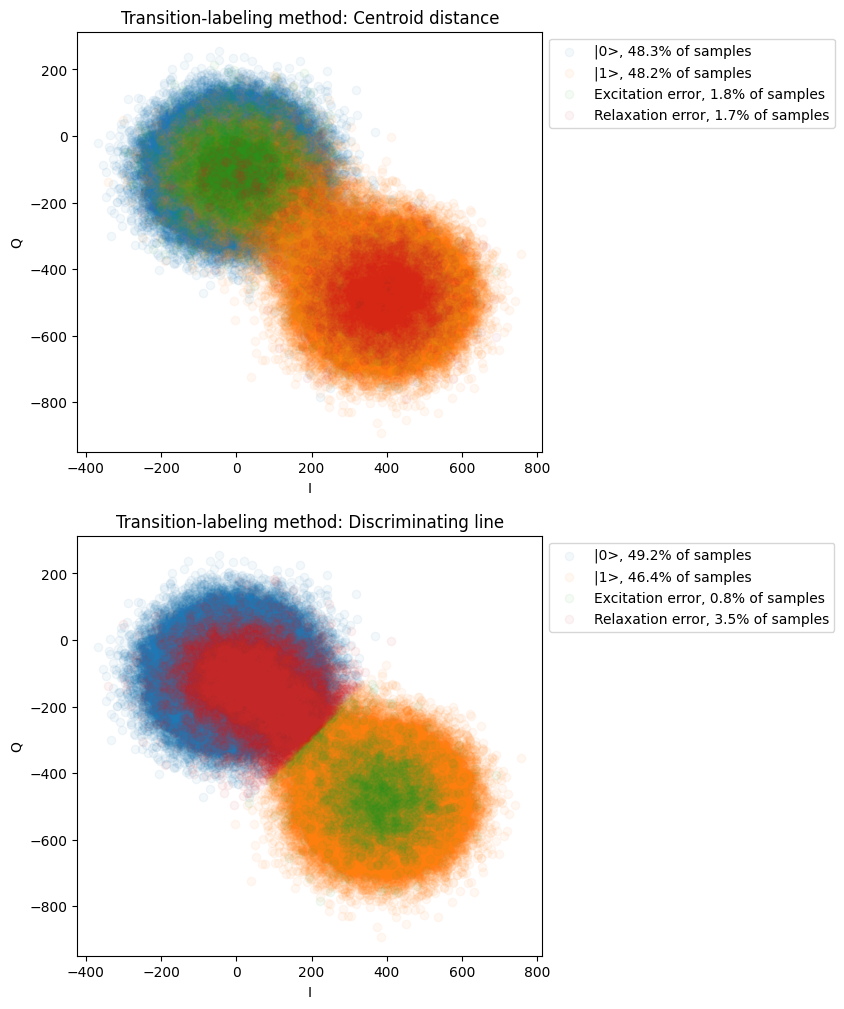

In [4]:
X_I_tmean, X_Q_tmean = rad_labeler.split_and_time_average(X)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,12))

##################################### Centroid distance labeling #####################################

idx0_rad = np.where(y_rad==0)[0]
idx1_rad = np.where(y_rad==1)[0]
idx2_rad = np.where(y_rad==2)[0]
idx3_rad = np.where(y_rad==3)[0]

ax1.scatter(X_I_tmean[idx0_rad], X_Q_tmean[idx0_rad], label = f"|0>, {(100*len(idx0_rad)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax1.scatter(X_I_tmean[idx1_rad], X_Q_tmean[idx1_rad], label = f"|1>, {(100*len(idx1_rad)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax1.scatter(X_I_tmean[idx2_rad], X_Q_tmean[idx2_rad], label = f"Excitation error, {(100*len(idx2_rad)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax1.scatter(X_I_tmean[idx3_rad], X_Q_tmean[idx3_rad], label = f"Relaxation error, {(100*len(idx3_rad)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax1.set_xlabel("I")
ax1.set_ylabel("Q")
ax1.legend(bbox_to_anchor = [1,1])
ax1.set_title("Transition-labeling method: Centroid distance")

##################################### Discriminating line labeling #####################################

idx0_thresh = np.where(y_thresh==0)[0]
idx1_thresh = np.where(y_thresh==1)[0]
idx2_thresh = np.where(y_thresh==2)[0]
idx3_thresh = np.where(y_thresh==3)[0]

ax2.scatter(X_I_tmean[idx0_thresh], X_Q_tmean[idx0_thresh], label = f"|0>, {(100*len(idx0_thresh)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax2.scatter(X_I_tmean[idx1_thresh], X_Q_tmean[idx1_thresh], label = f"|1>, {(100*len(idx1_thresh)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax2.scatter(X_I_tmean[idx2_thresh], X_Q_tmean[idx2_thresh], label = f"Excitation error, {(100*len(idx2_thresh)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax2.scatter(X_I_tmean[idx3_thresh], X_Q_tmean[idx3_thresh], label = f"Relaxation error, {(100*len(idx3_thresh)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax2.set_xlabel("I")
ax2.set_ylabel("Q")
ax2.legend(bbox_to_anchor = [1,1])
ax2.set_title("Transition-labeling method: Discriminating line")

## Fourier transform 

First, convert to complex numbers, then amplitude and phase

In [5]:
# Convert to complex
X_I = X[:, [i for i in range(X.shape[1]) if i%2==0]]
X_Q = X[:, [i for i in range(X.shape[1]) if i%2==1]]
X_complex = X_I + 1j*X_Q

# Fourier transform
X_fft = np.fft.fft(X_complex, axis=1)

# Order by increasing frequency 
X_fft_freqs = np.fft.fftfreq(X_complex.shape[1])/(3.25e-9)
freq_ordering = np.argsort(X_fft_freqs)
X_fft_freqs = X_fft_freqs[freq_ordering]
X_fft = X_fft[:, freq_ordering]

## Differences based on centroid-distance labels

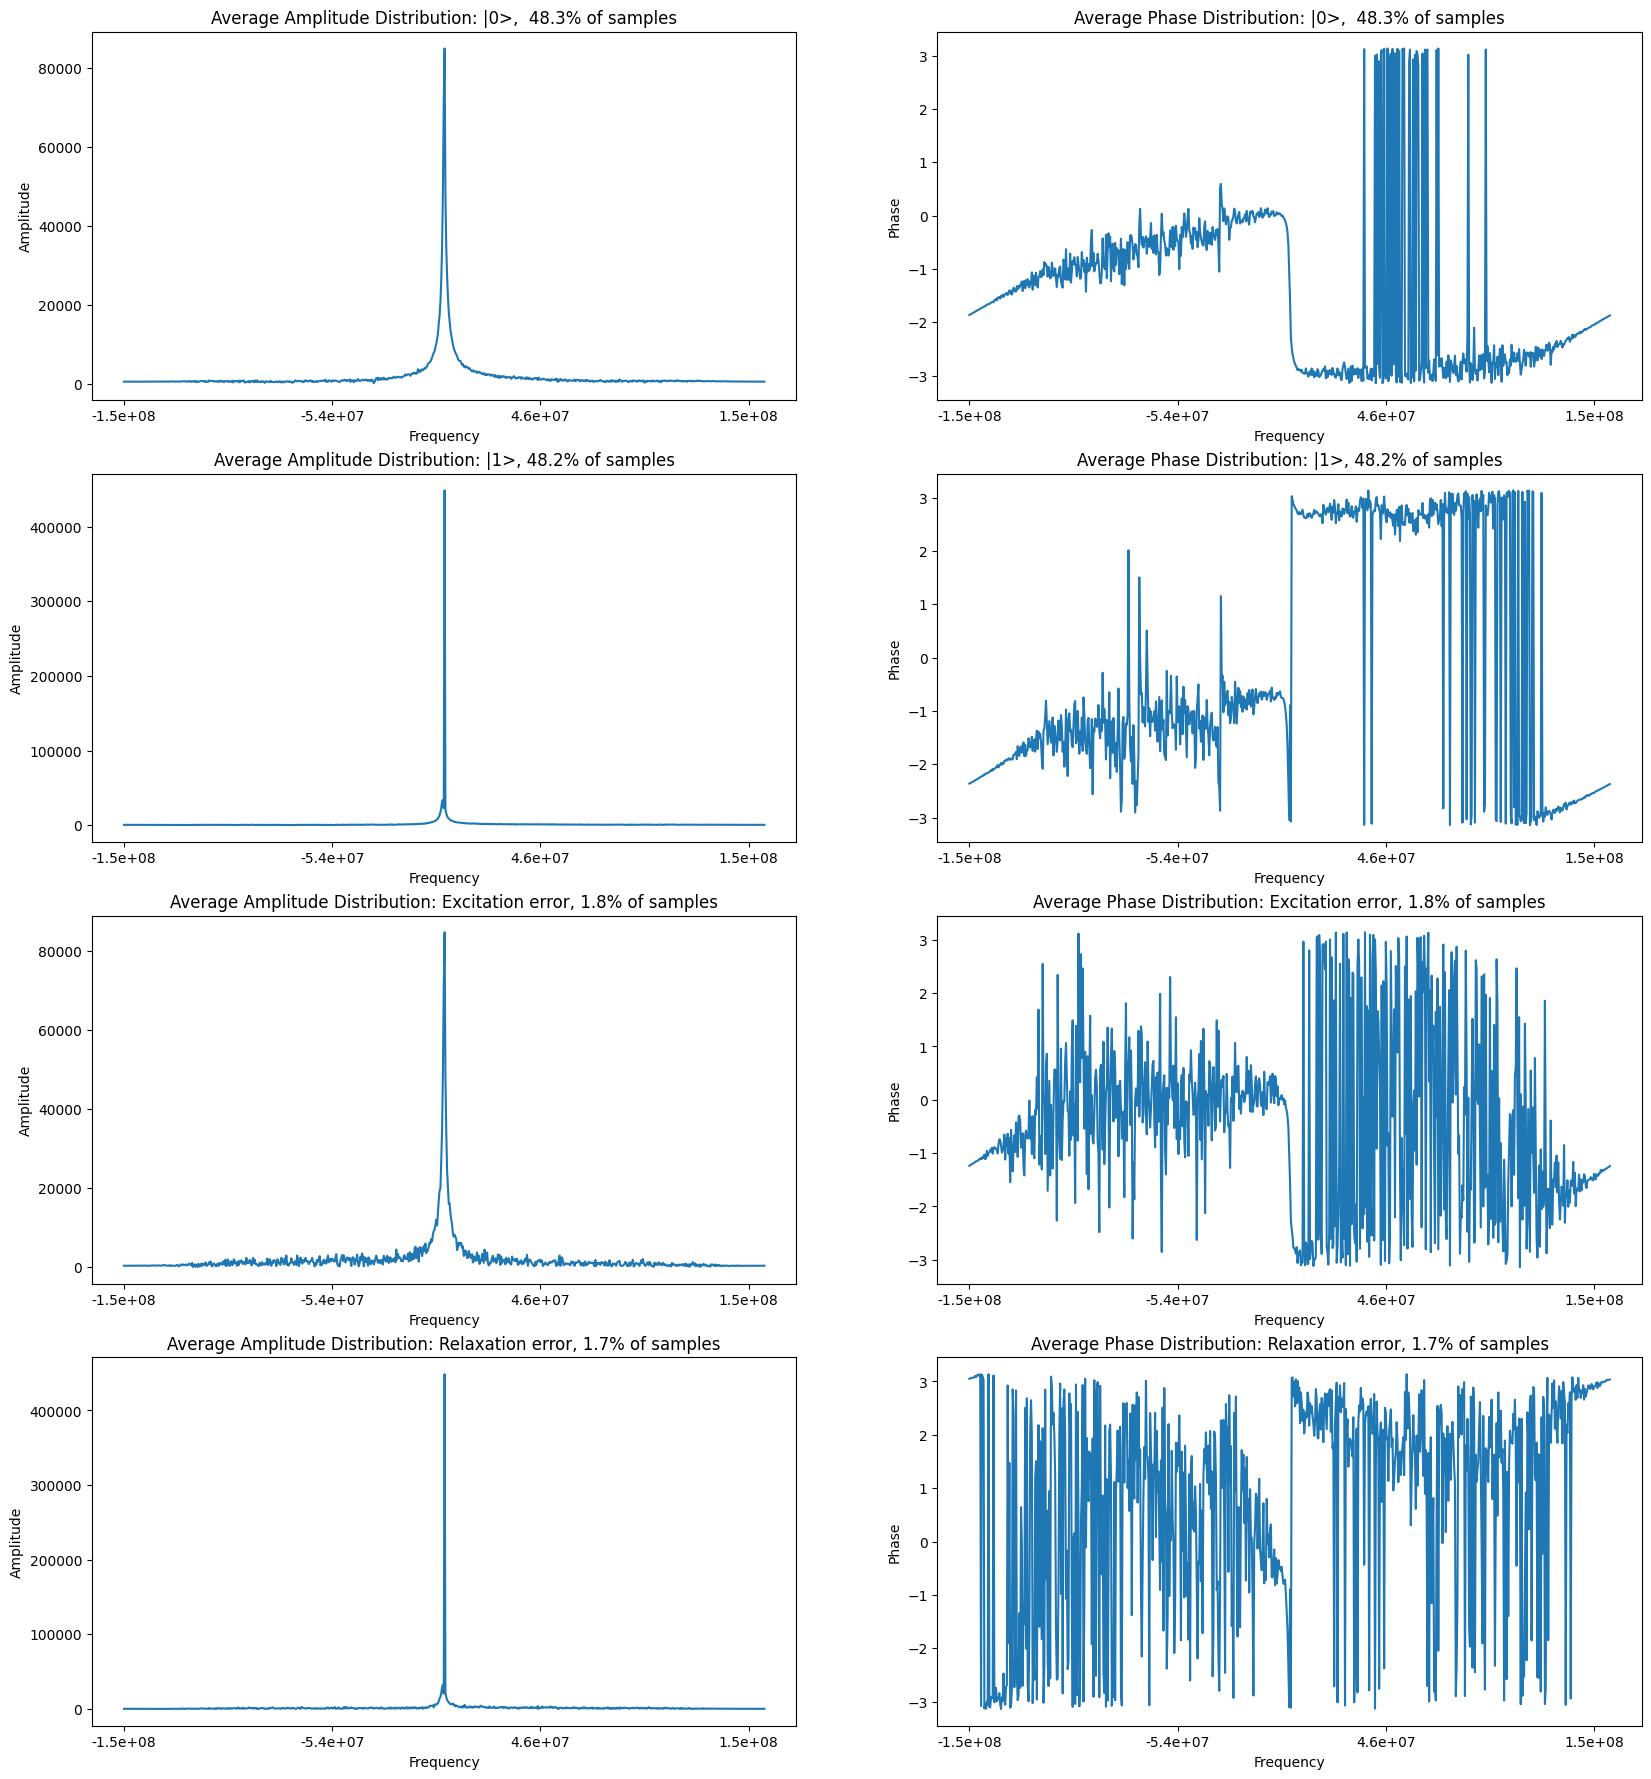

In [6]:
fig, axes = plt.subplots(4, 2, figsize = (20, 22))
labels = [0, 1, 2, 3]
label_legends = {0: f"|0>,  {(100*len(idx0_rad)/X.shape[0]):.1f}% of samples", 
                 1: f"|1>, {(100*len(idx1_rad)/X.shape[0]):.1f}% of samples", 
                2: f"Excitation error, {(100*len(idx2_rad)/X.shape[0]):.1f}% of samples",
                3: f"Relaxation error, {(100*len(idx3_rad)/X.shape[0]):.1f}% of samples"}

for label in labels:
    label_idx = np.where(y_rad==label)[0]
    label_legend = label_legends[label]

    X_fft_label_mean = np.mean(X_fft[label_idx], axis=0)
    X_amp_label_mean = np.abs(X_fft_label_mean)
    X_phase_label_mean = np.angle(X_fft_label_mean)
    
    axes[label, 0].plot(X_amp_label_mean, label = label_legend)
    axes[label, 1].plot(X_phase_label_mean, label = label_legend)
    axes[label, 0].set_xlabel("Frequency")
    axes[label, 0].set_ylabel("Amplitude")
    axes[label, 0].set_xticks(ticks = [i for i in range(X_fft.shape[1]) if i%250==0], labels = [f"{X_fft_freqs[i]:.1e}" for i in range(X_fft.shape[1]) if i%250==0])
    axes[label, 0].set_title(f"Average Amplitude Distribution: {label_legends[label]}")
    
    axes[label, 1].set_xlabel("Frequency")
    axes[label, 1].set_ylabel("Phase")
    axes[label, 1].set_xticks(ticks = [i for i in range(X_fft.shape[1]) if i%250==0], labels = [f"{X_fft_freqs[i]:.1e}" for i in range(X_fft.shape[1]) if i%250==0])
    axes[label, 1].set_title(f"Average Phase Distribution: {label_legends[label]}")


## Differences based on discriminating line

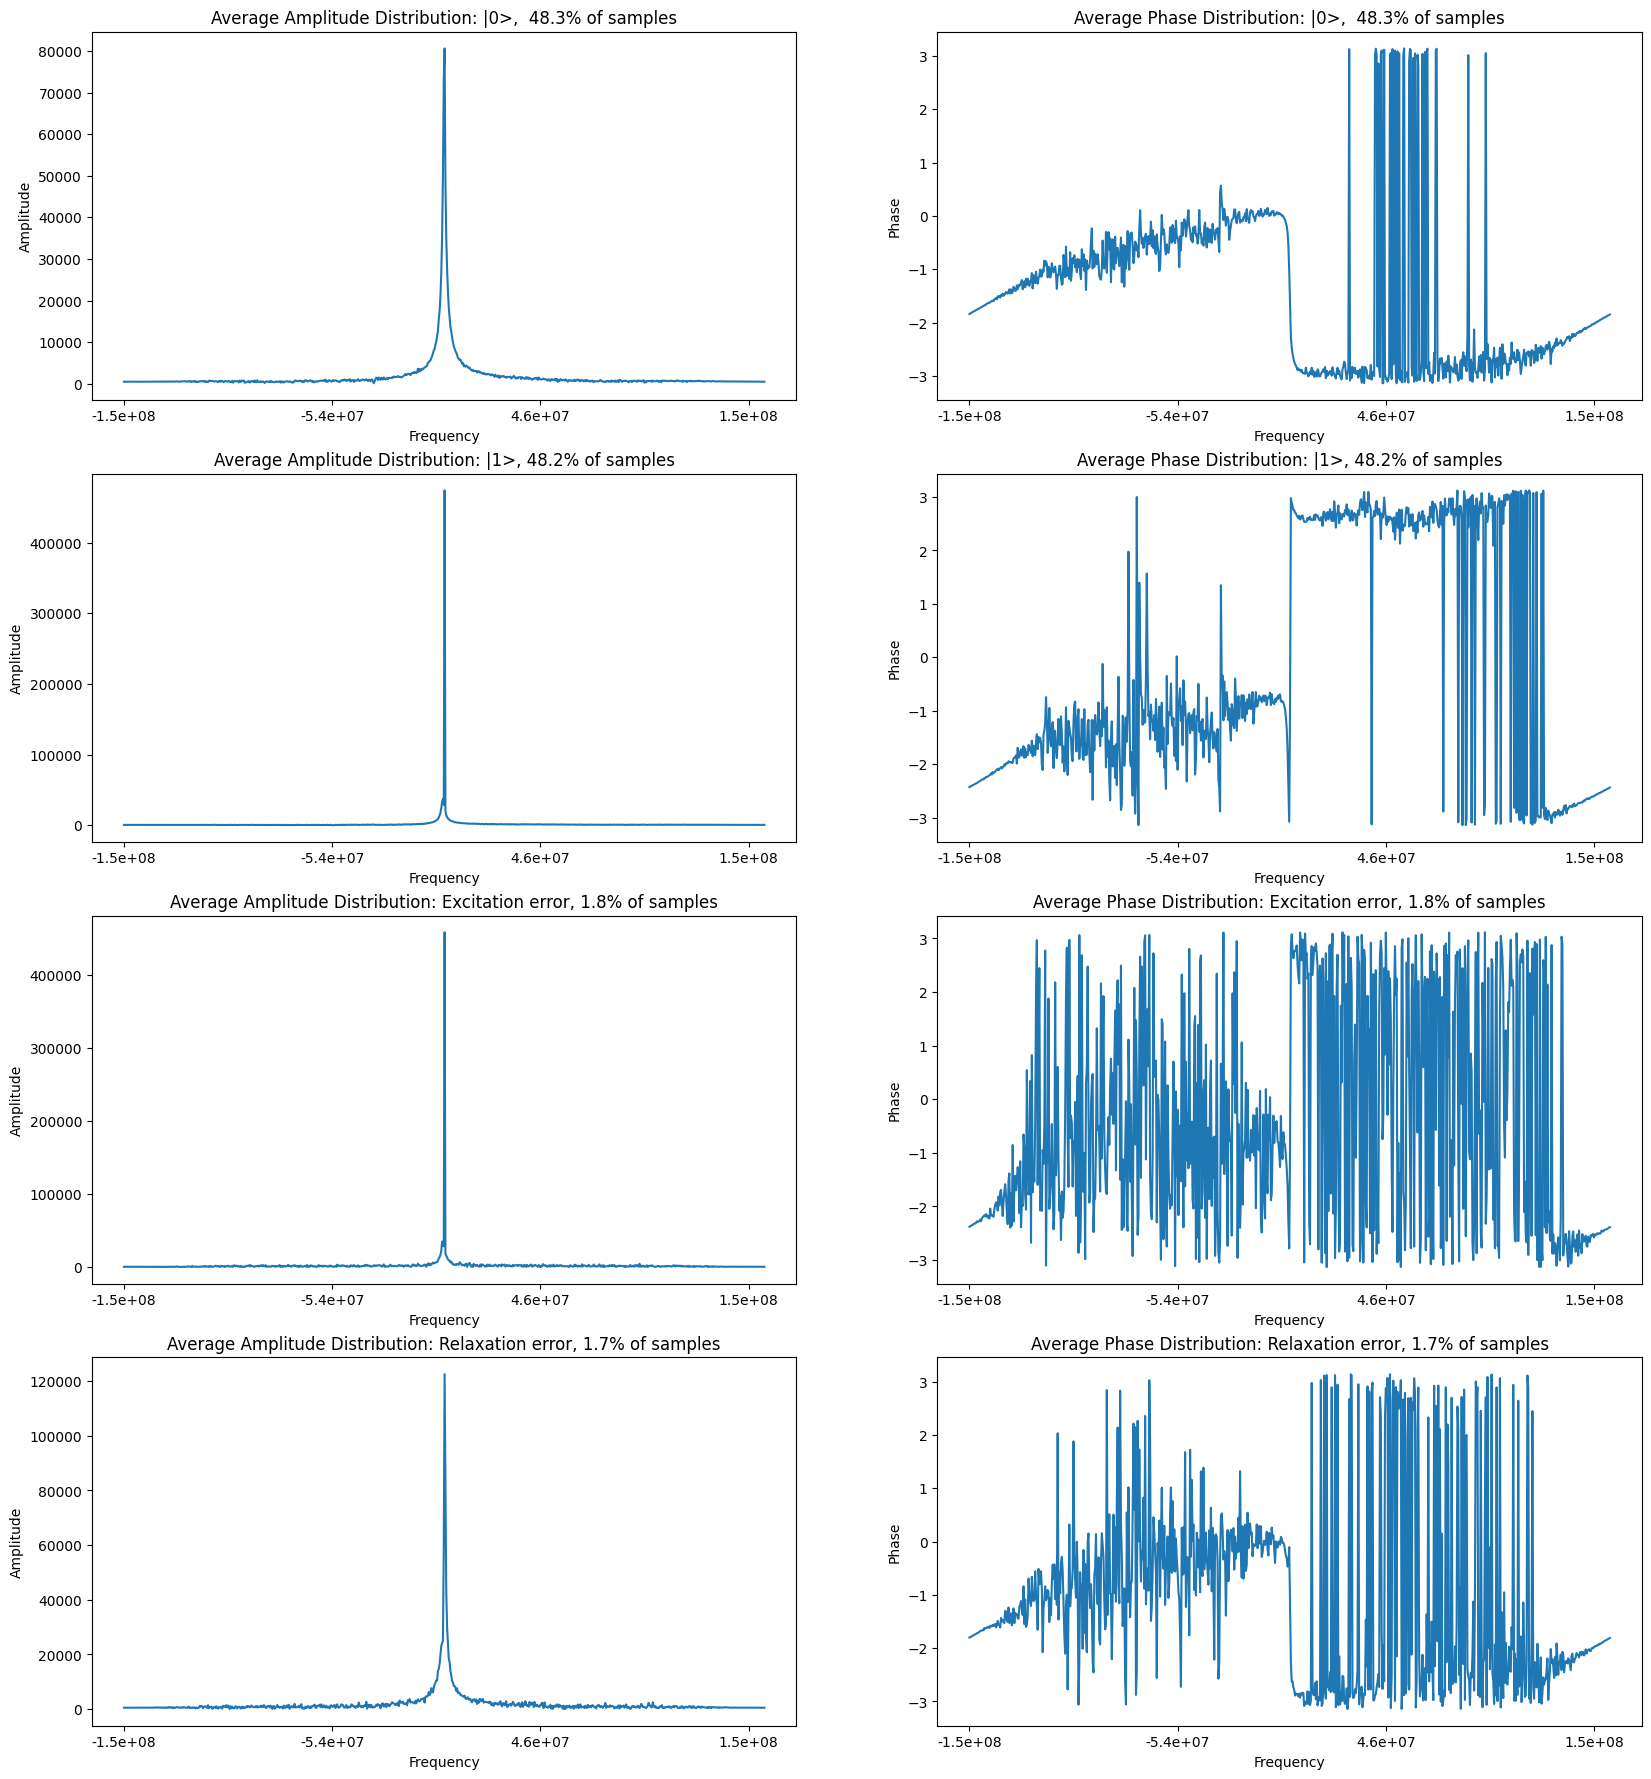

In [7]:
fig, axes = plt.subplots(4, 2, figsize = (20, 22))

for label in labels:
    label_idx = np.where(y_thresh==label)[0]
    label_legend = label_legends[label]

    X_fft_label_mean = np.mean(X_fft[label_idx], axis=0)
    X_amp_label_mean = np.abs(X_fft_label_mean)
    X_phase_label_mean = np.angle(X_fft_label_mean)
    
    axes[label, 0].plot(X_amp_label_mean, label = label_legend)
    axes[label, 1].plot(X_phase_label_mean, label = label_legend)
    axes[label, 0].set_xlabel("Frequency")
    axes[label, 0].set_ylabel("Amplitude")
    axes[label, 0].set_xticks(ticks = [i for i in range(X_fft.shape[1]) if i%250==0], labels = [f"{X_fft_freqs[i]:.1e}" for i in range(X_fft.shape[1]) if i%250==0])
    axes[label, 0].set_title(f"Average Amplitude Distribution: {label_legends[label]}")
    
    axes[label, 1].set_xlabel("Frequency")
    axes[label, 1].set_ylabel("Phase")
    axes[label, 1].set_xticks(ticks = [i for i in range(X_fft.shape[1]) if i%250==0], labels = [f"{X_fft_freqs[i]:.1e}" for i in range(X_fft.shape[1]) if i%250==0])
    axes[label, 1].set_title(f"Average Phase Distribution: {label_legends[label]}")
    

## Centroid labeling: near 1MHz

In [8]:
freqs_min_1MHz = np.abs(X_fft_freqs - 1e6)
idx_1mhz = np.where(freqs_min_1MHz==min(freqs_min_1MHz))[0]
ran = 100

X_fft_freqs_zoomed = X_fft_freqs[int(idx_1mhz-ran):int(idx_1mhz+ran)]

xticks = [i for i in range(X_fft_freqs_zoomed.shape[0]) if i%50==0]
xlabels = [f"{X_fft_freqs_zoomed[i]:.1e}" for i in range(X_fft_freqs_zoomed.shape[0]) if i%50==0]
xlims = (min(xticks), max(xticks))

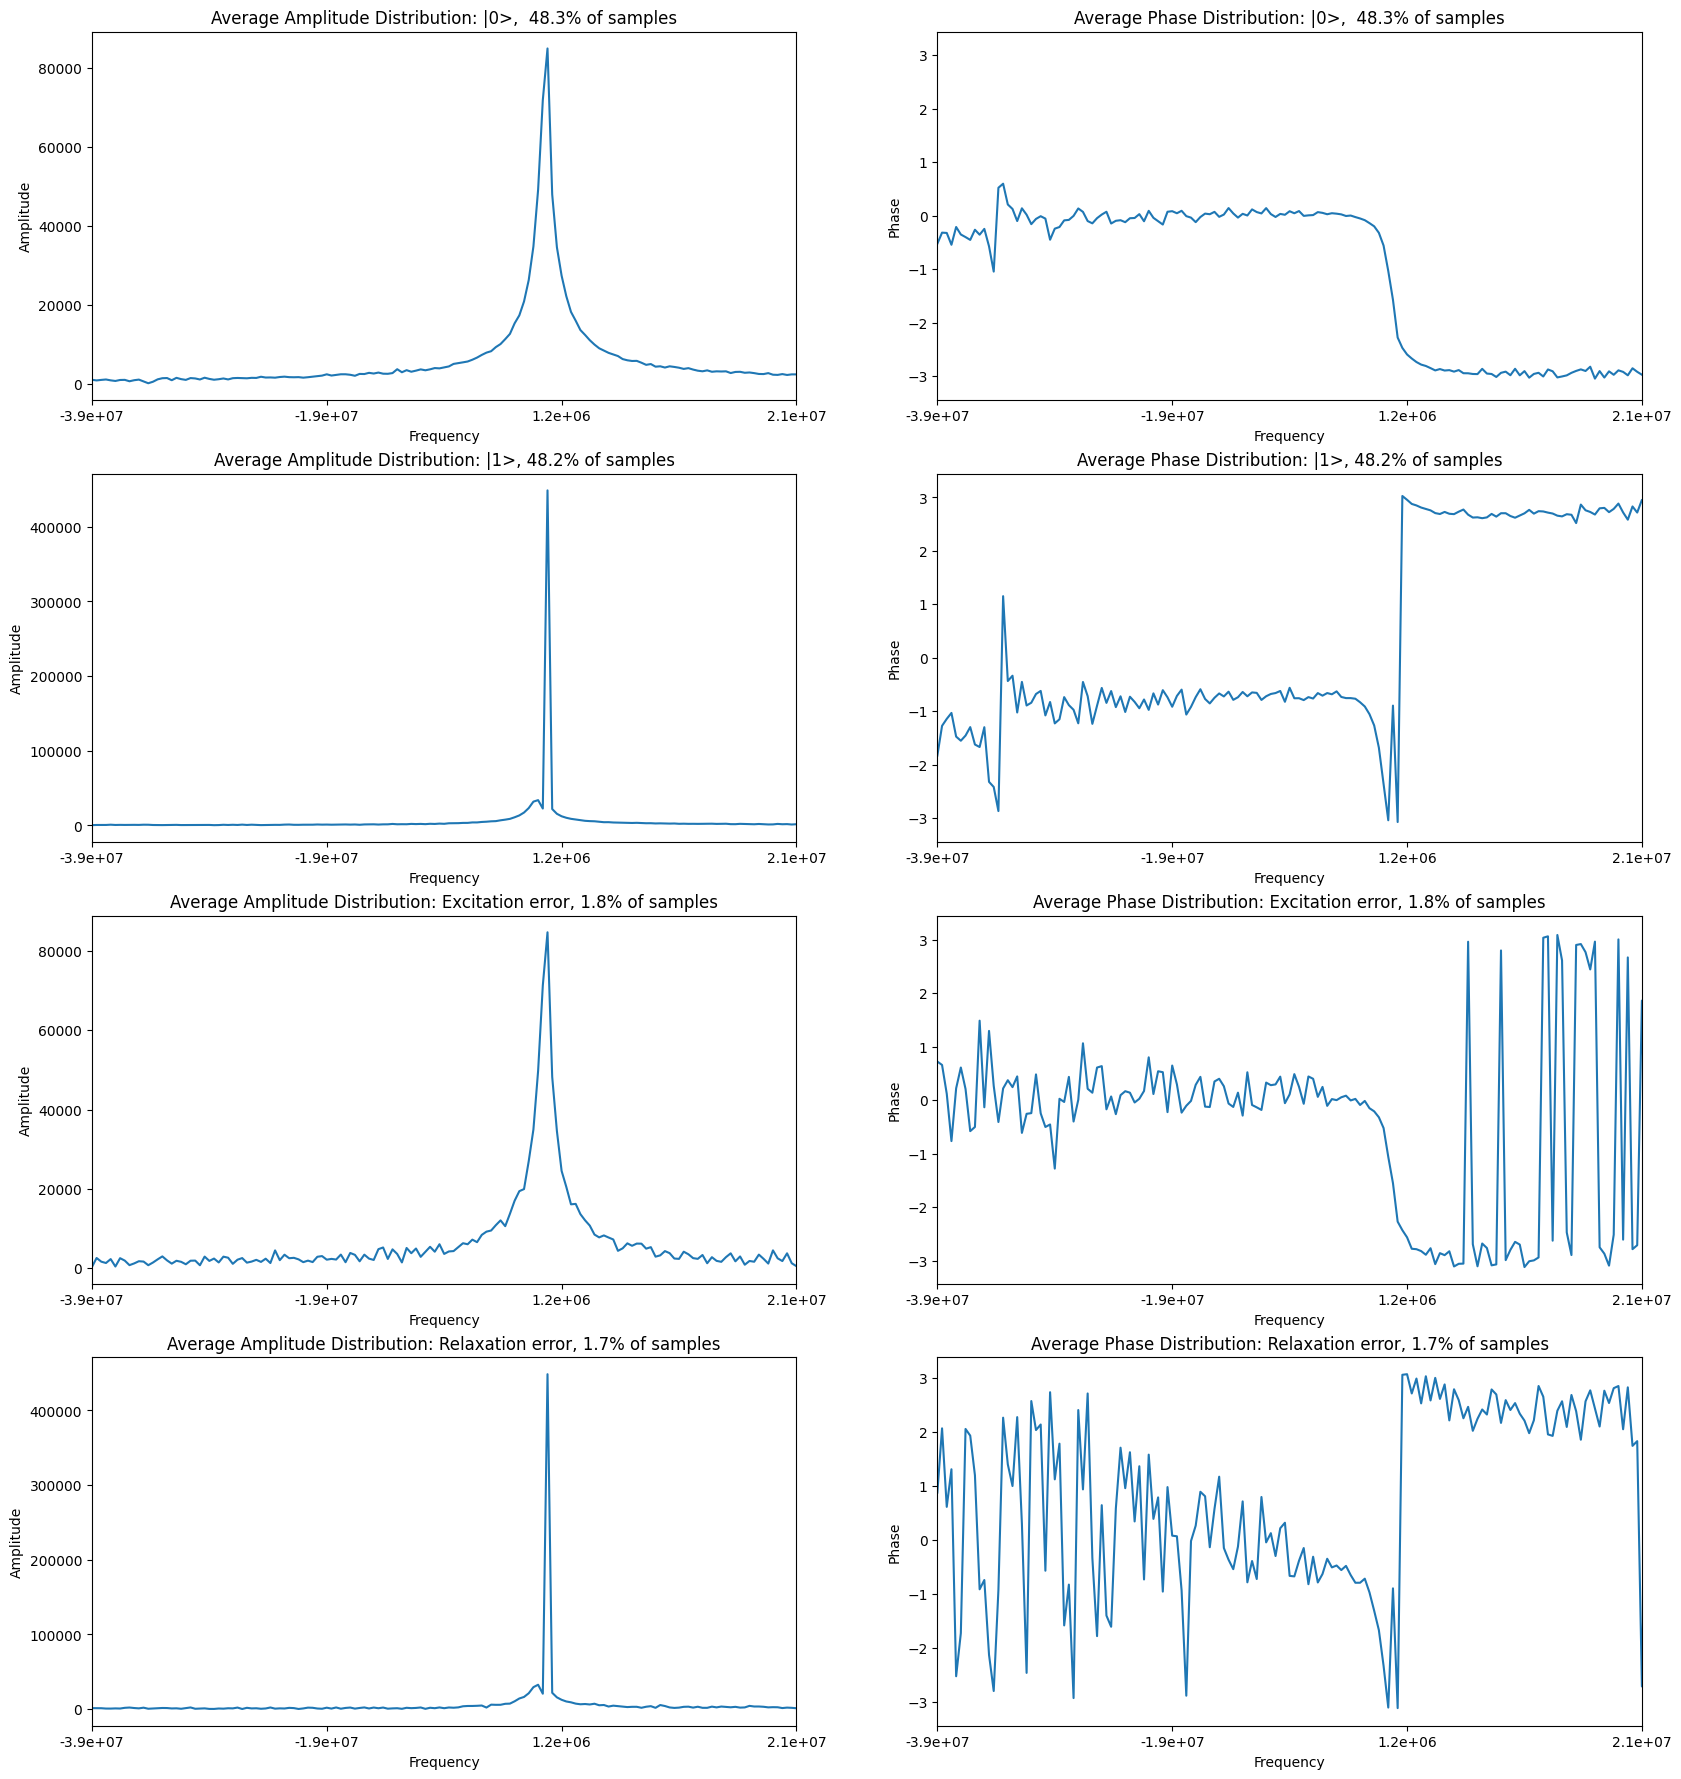

In [16]:
fig, axes = plt.subplots(4, 2, figsize = (20, 22))

for label in labels:
    label_idx = np.where(y_rad==label)[0]
    label_legend = label_legends[label]

    X_fft_label_mean = np.mean(X_fft[label_idx], axis=0)
    X_amp_label_mean = np.abs(X_fft_label_mean)
    X_phase_label_mean = np.angle(X_fft_label_mean)
    
    axes[label, 0].plot(X_amp_label_mean[int(idx_1mhz-ran):int(idx_1mhz+ran)], label = label_legend)
    axes[label, 0].set_xlabel("Frequency")
    axes[label, 0].set_ylabel("Amplitude")
    axes[label, 0].set_xticks(ticks = xticks, labels = xlabels)
    axes[label, 0].set_xlim(xlims)
    axes[label, 0].set_title(f"Average Amplitude Distribution: {label_legends[label]}")

    axes[label, 1].plot(X_phase_label_mean[int(idx_1mhz-ran):int(idx_1mhz+ran)], label = label_legend)
    axes[label, 1].set_xlabel("Frequency")
    axes[label, 1].set_ylabel("Phase")
    axes[label, 1].set_xticks(ticks = xticks, labels = xlabels)
    axes[label, 1].set_xlim(xlims)
    axes[label, 1].set_title(f"Average Phase Distribution: {label_legends[label]}")


## Threshold labeling: near 1MHz

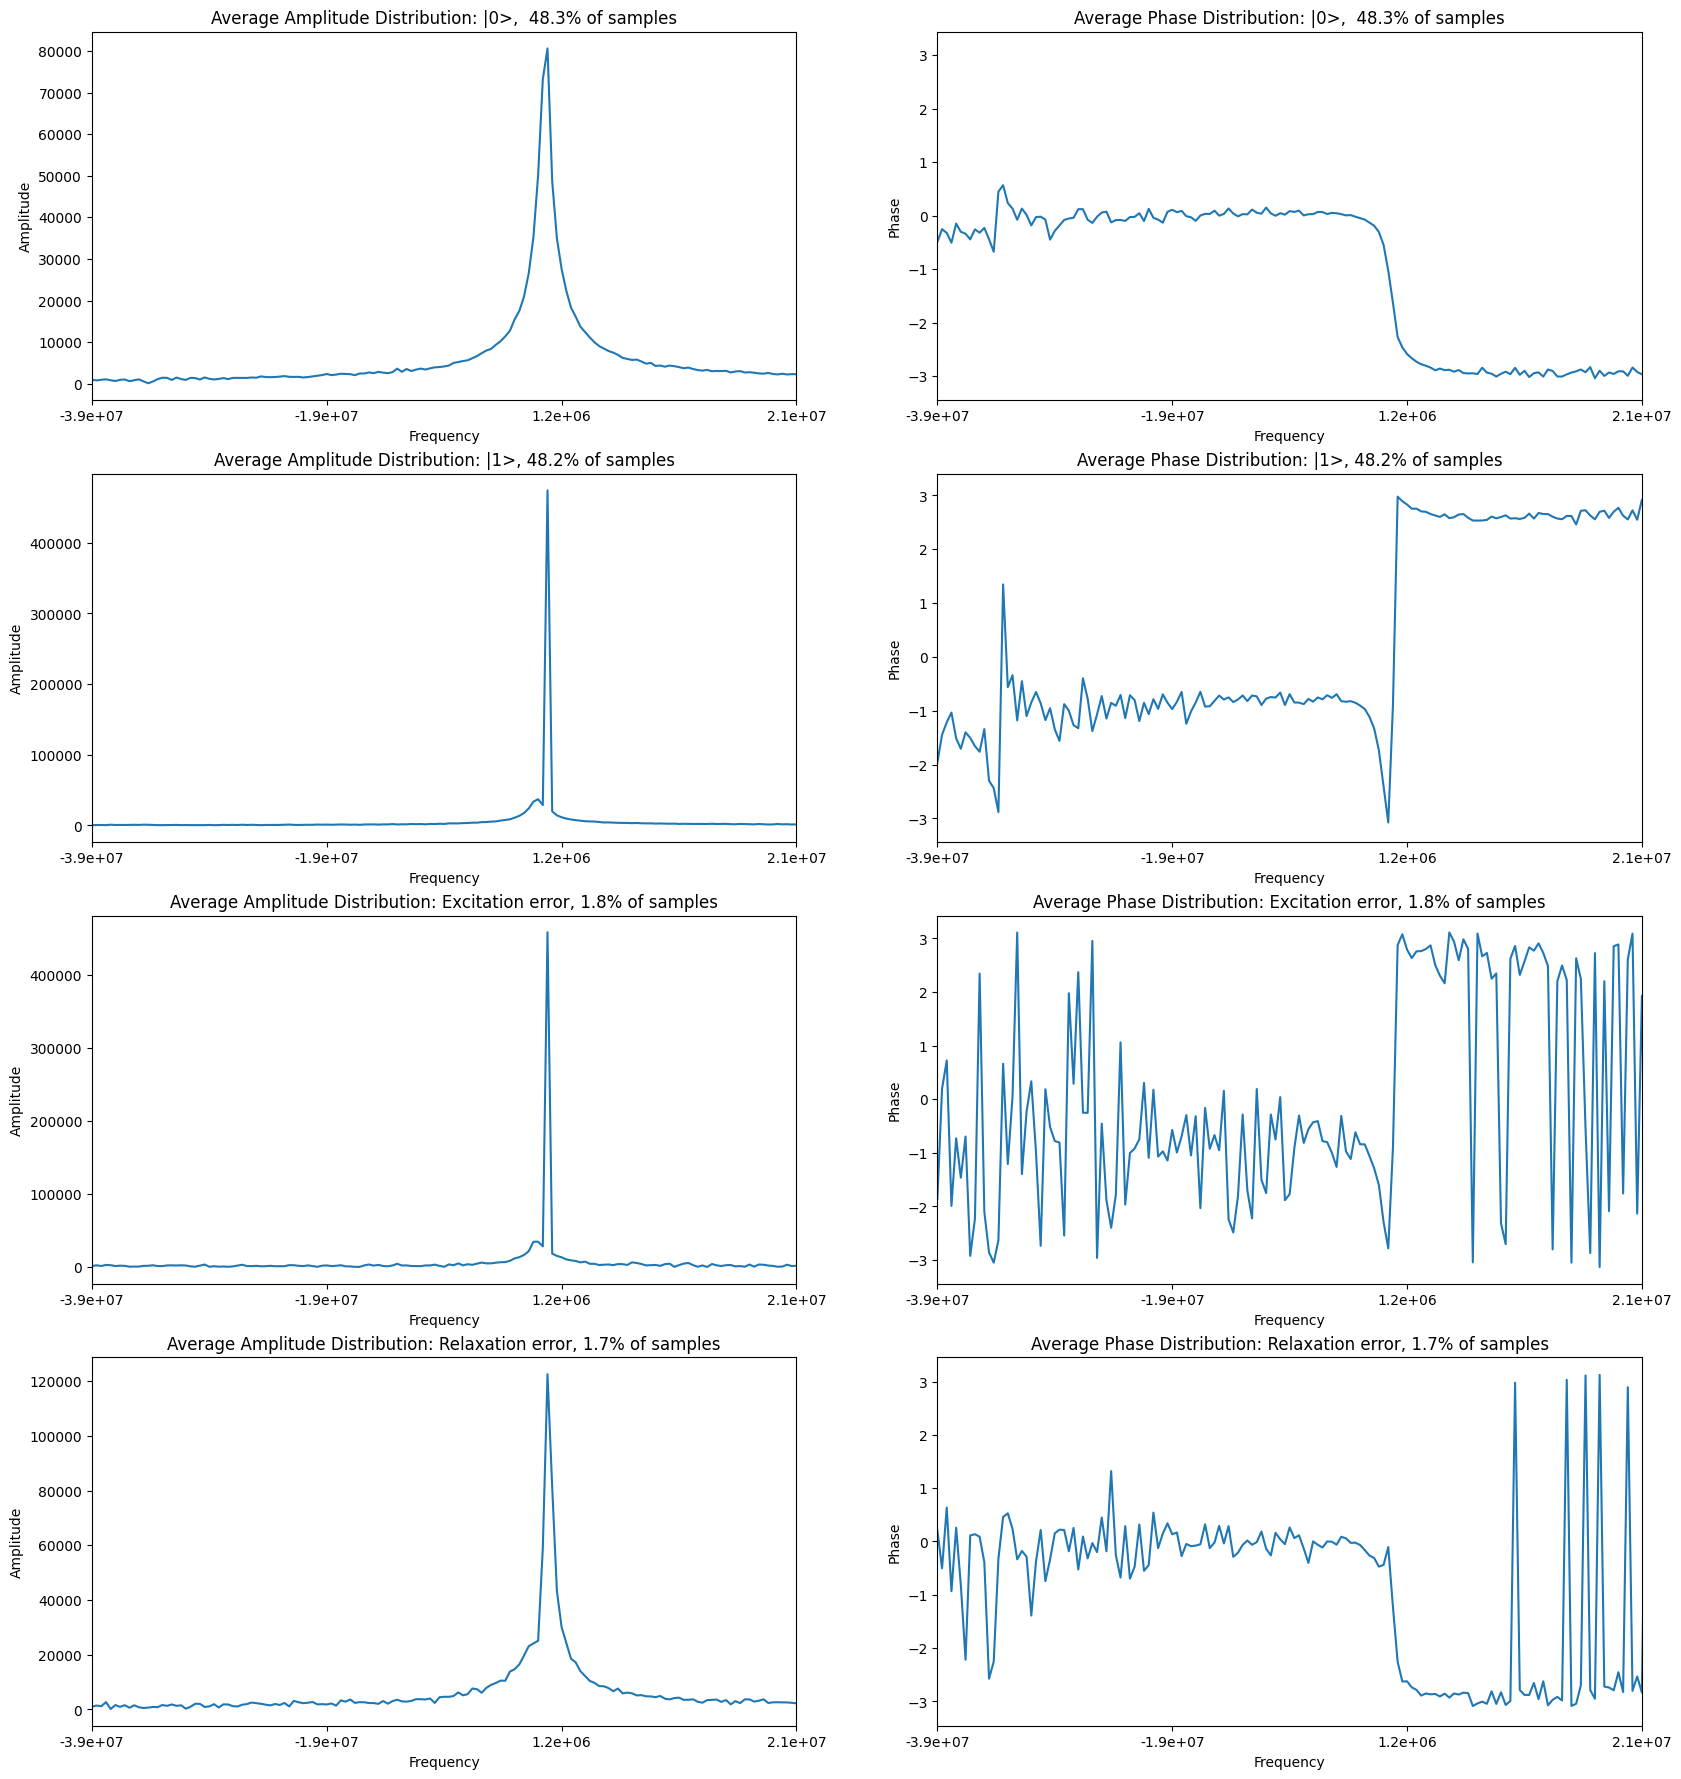

In [15]:
fig, axes = plt.subplots(4, 2, figsize = (20, 22))

for label in labels:
    label_idx = np.where(y_thresh==label)[0]
    label_legend = label_legends[label]

    X_fft_label_mean = np.mean(X_fft[label_idx], axis=0)
    X_amp_label_mean = np.abs(X_fft_label_mean)
    X_phase_label_mean = np.angle(X_fft_label_mean)
    
    axes[label, 0].plot(X_amp_label_mean[int(idx_1mhz-ran):int(idx_1mhz+ran)], label = label_legend)
    axes[label, 0].set_xlabel("Frequency")
    axes[label, 0].set_ylabel("Amplitude")
    axes[label, 0].set_xticks(ticks = xticks, labels = xlabels)
    axes[label, 0].set_xlim(xlims)
    axes[label, 0].set_title(f"Average Amplitude Distribution: {label_legends[label]}")

    axes[label, 1].plot(X_phase_label_mean[int(idx_1mhz-ran):int(idx_1mhz+ran)], label = label_legend)
    axes[label, 1].set_xlabel("Frequency")
    axes[label, 1].set_ylabel("Phase")
    axes[label, 1].set_xticks(ticks = xticks, labels = xlabels)
    axes[label, 1].set_xlim(xlims)
    axes[label, 1].set_title(f"Average Phase Distribution: {label_legends[label]}")


## Sliding window average of FT's

In [34]:
WINDOW_SIZE = 5
X_fft_smoothed = np.zeros(X_fft.shape, dtype=np.complex128)

for i in range(WINDOW_SIZE, X_fft.shape[1]):
    window_avg = np.mean(X_fft[:, i-WINDOW_SIZE:i], axis=1)
    X_fft_smoothed[:, i] = window_avg

X_fft_smoothed = X_fft_smoothed[:, WINDOW_SIZE:]


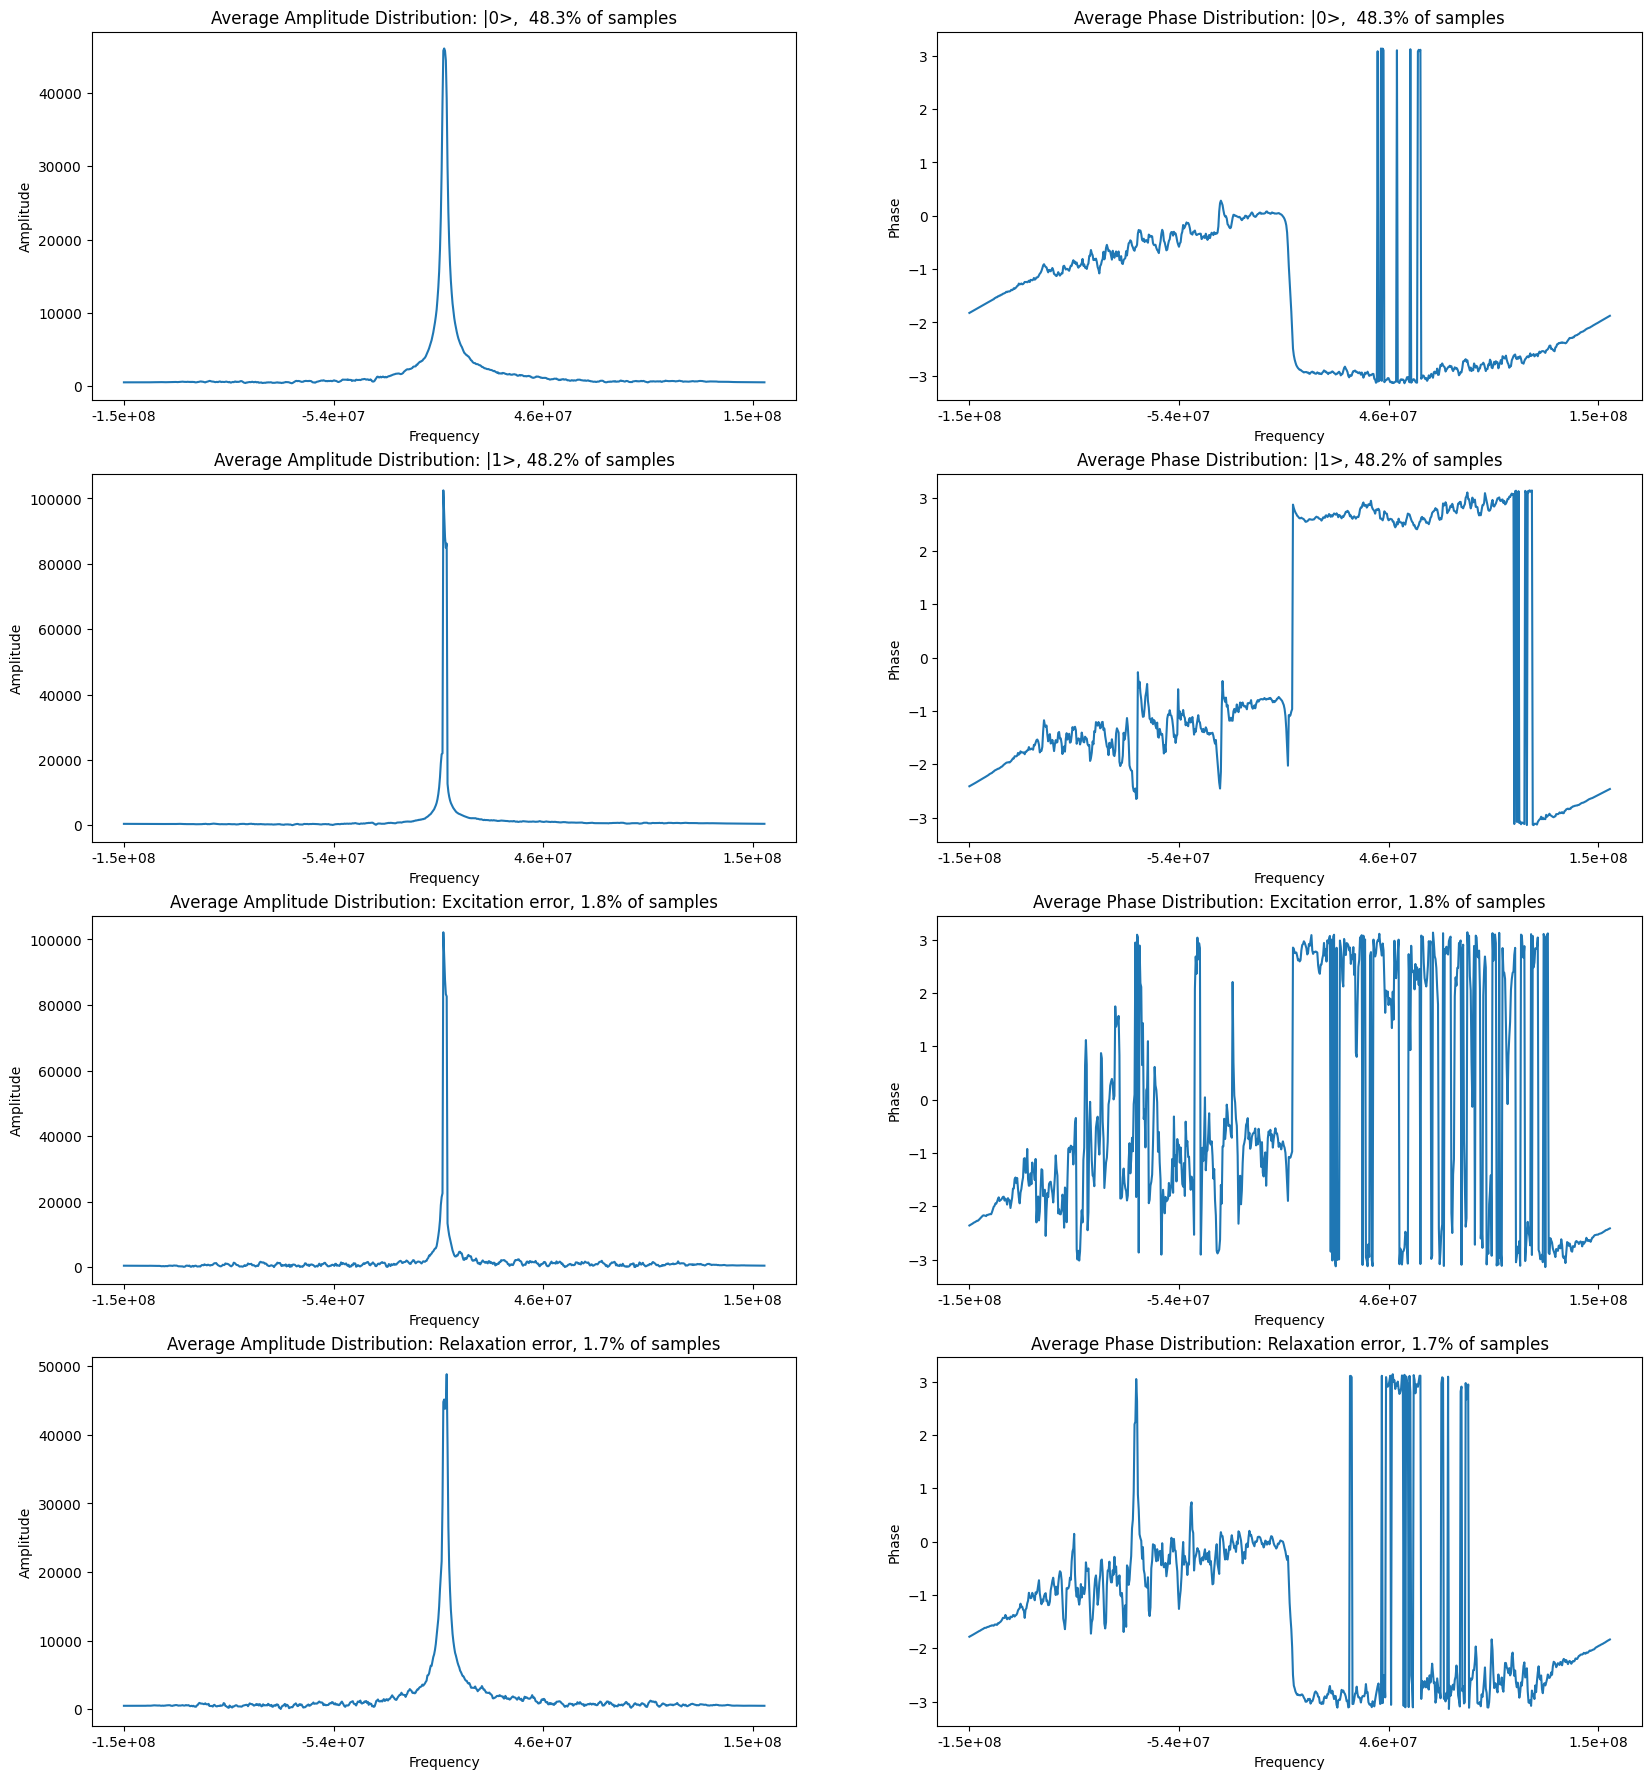

In [36]:
fig, axes = plt.subplots(4, 2, figsize = (20, 22))

for label in labels:
    label_idx = np.where(y_thresh==label)[0]
    label_legend = label_legends[label]

    X_fft_label_mean = np.mean(X_fft_smoothed[label_idx], axis=0)
    X_amp_label_mean = np.abs(X_fft_label_mean)
    X_phase_label_mean = np.angle(X_fft_label_mean)
    
    axes[label, 0].plot(X_amp_label_mean, label = label_legend)
    axes[label, 1].plot(X_phase_label_mean, label = label_legend)
    axes[label, 0].set_xlabel("Frequency")
    axes[label, 0].set_ylabel("Amplitude")
    axes[label, 0].set_xticks(ticks = [i for i in range(X_fft.shape[1]) if i%250==0], labels = [f"{X_fft_freqs[i]:.1e}" for i in range(X_fft.shape[1]) if i%250==0])
    axes[label, 0].set_title(f"Average Amplitude Distribution: {label_legends[label]}")
    
    axes[label, 1].set_xlabel("Frequency")
    axes[label, 1].set_ylabel("Phase")
    axes[label, 1].set_xticks(ticks = [i for i in range(X_fft.shape[1]) if i%250==0], labels = [f"{X_fft_freqs[i]:.1e}" for i in range(X_fft.shape[1]) if i%250==0])
    axes[label, 1].set_title(f"Average Phase Distribution: {label_legends[label]}")
    

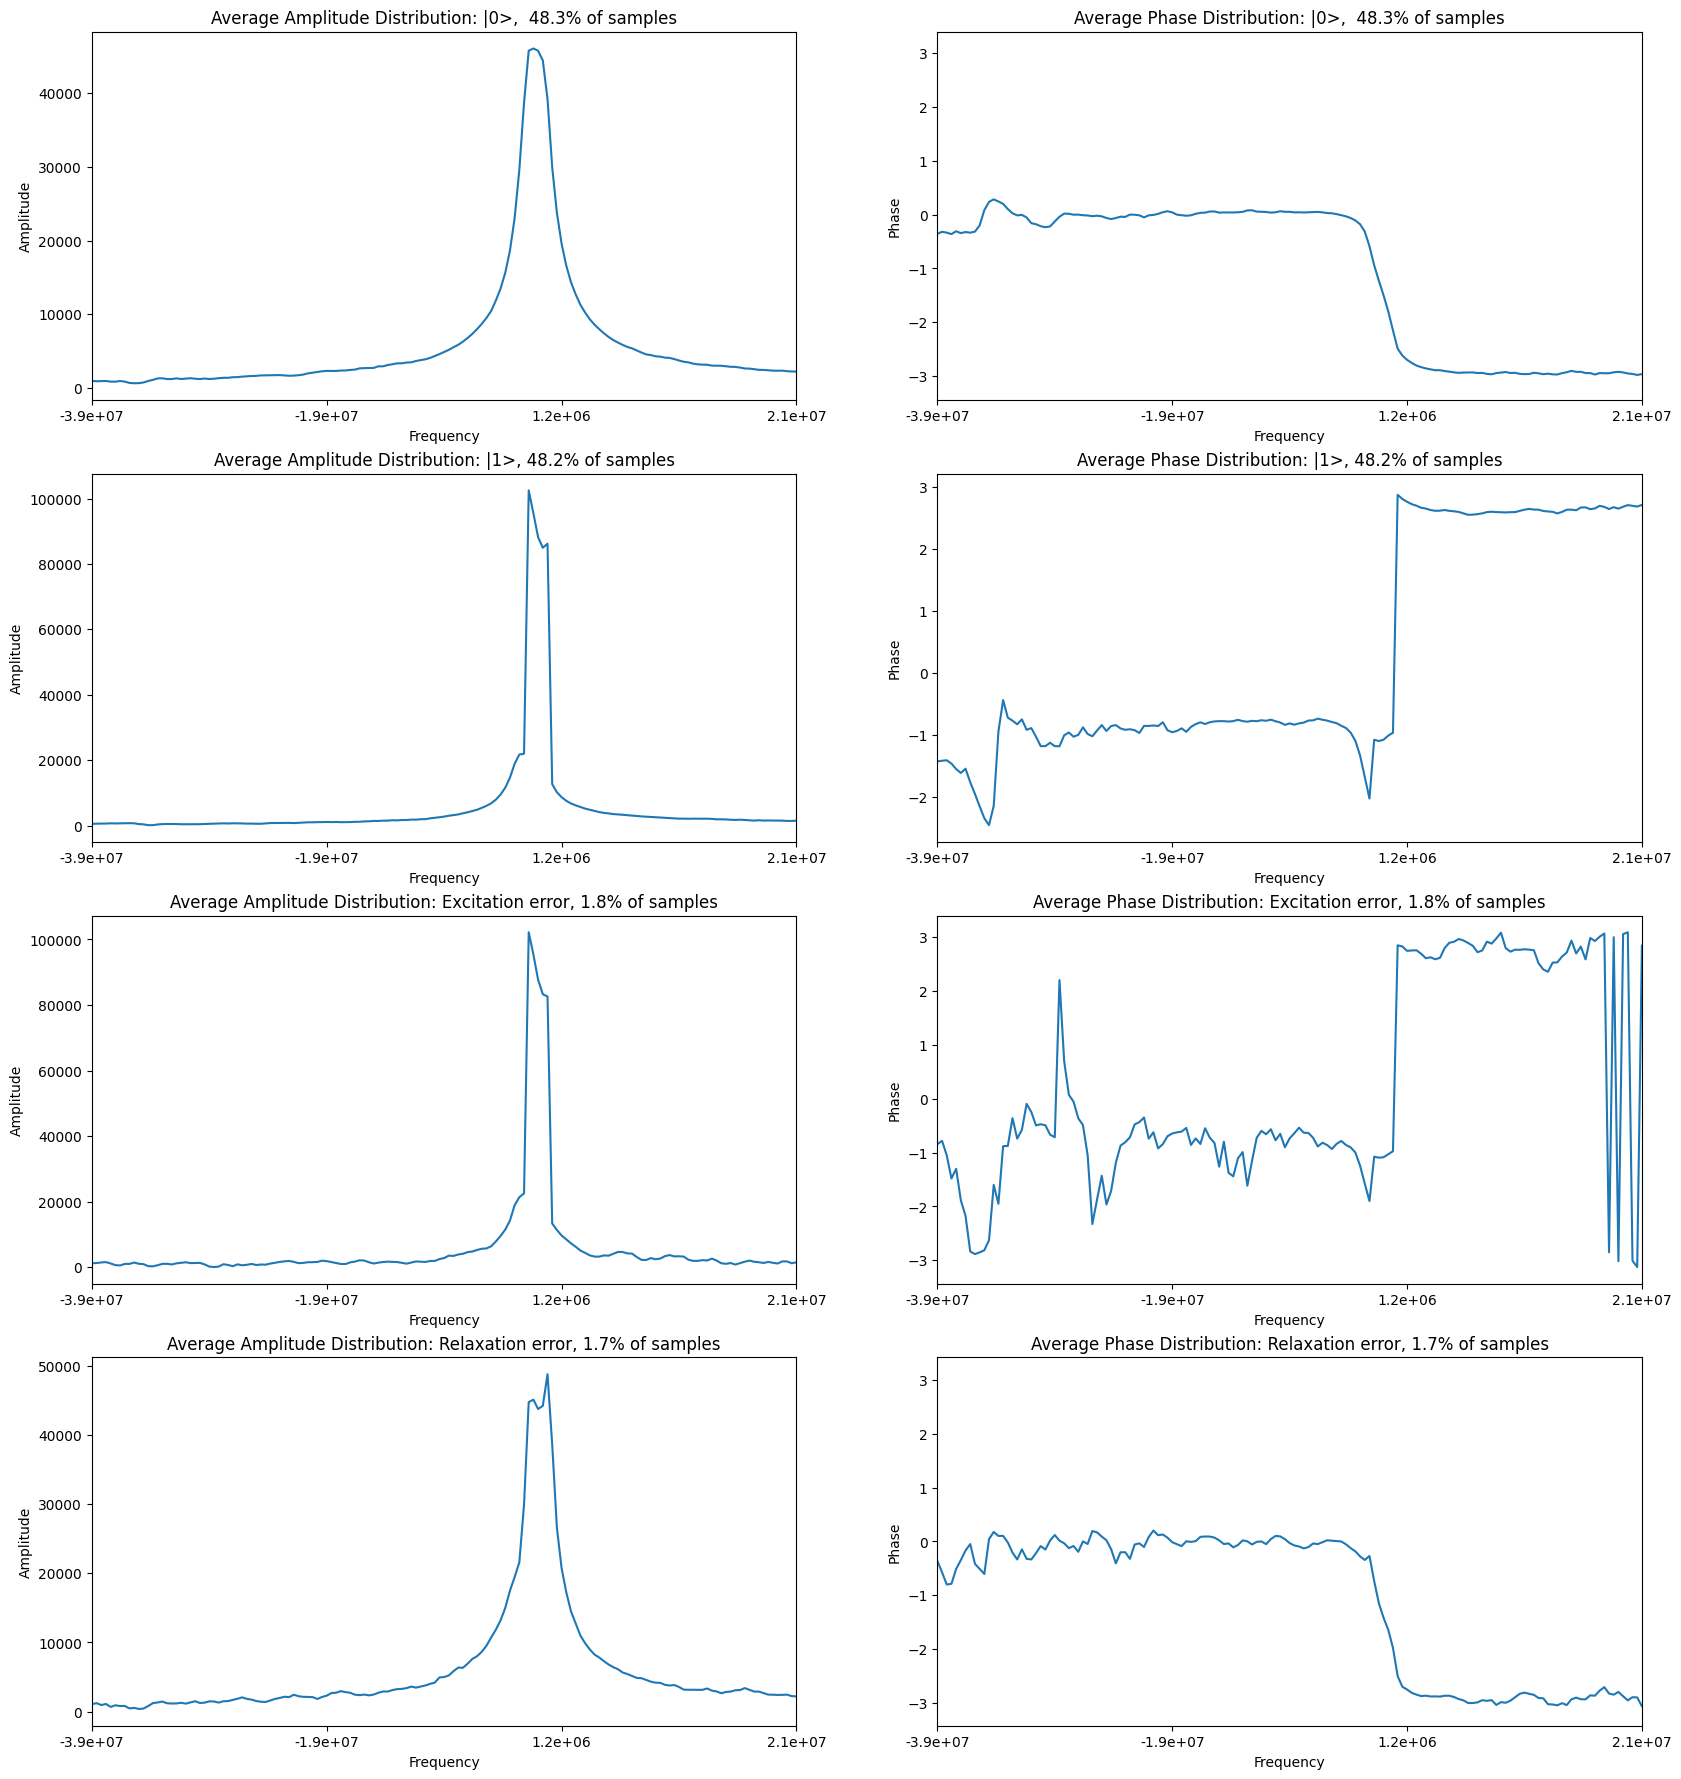

In [37]:
fig, axes = plt.subplots(4, 2, figsize = (20, 22))

for label in labels:
    label_idx = np.where(y_thresh==label)[0]
    label_legend = label_legends[label]

    X_fft_label_mean = np.mean(X_fft_smoothed[label_idx], axis=0)
    X_amp_label_mean = np.abs(X_fft_label_mean)
    X_phase_label_mean = np.angle(X_fft_label_mean)
    
    axes[label, 0].plot(X_amp_label_mean[int(idx_1mhz-ran):int(idx_1mhz+ran)], label = label_legend)
    axes[label, 0].set_xlabel("Frequency")
    axes[label, 0].set_ylabel("Amplitude")
    axes[label, 0].set_xticks(ticks = xticks, labels = xlabels)
    axes[label, 0].set_xlim(xlims)
    axes[label, 0].set_title(f"Average Amplitude Distribution: {label_legends[label]}")

    axes[label, 1].plot(X_phase_label_mean[int(idx_1mhz-ran):int(idx_1mhz+ran)], label = label_legend)
    axes[label, 1].set_xlabel("Frequency")
    axes[label, 1].set_ylabel("Phase")
    axes[label, 1].set_xticks(ticks = xticks, labels = xlabels)
    axes[label, 1].set_xlim(xlims)
    axes[label, 1].set_title(f"Average Phase Distribution: {label_legends[label]}")


## Find exact transition frequency

In [39]:
X_fft_smoothed_diff = np.diff(X_fft_smoothed)
max_idx = np.where(X_fft_smoothed_diff==max(X_fft_smoothed_diff))[0]
print(f"max_idx = {max_idx}")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

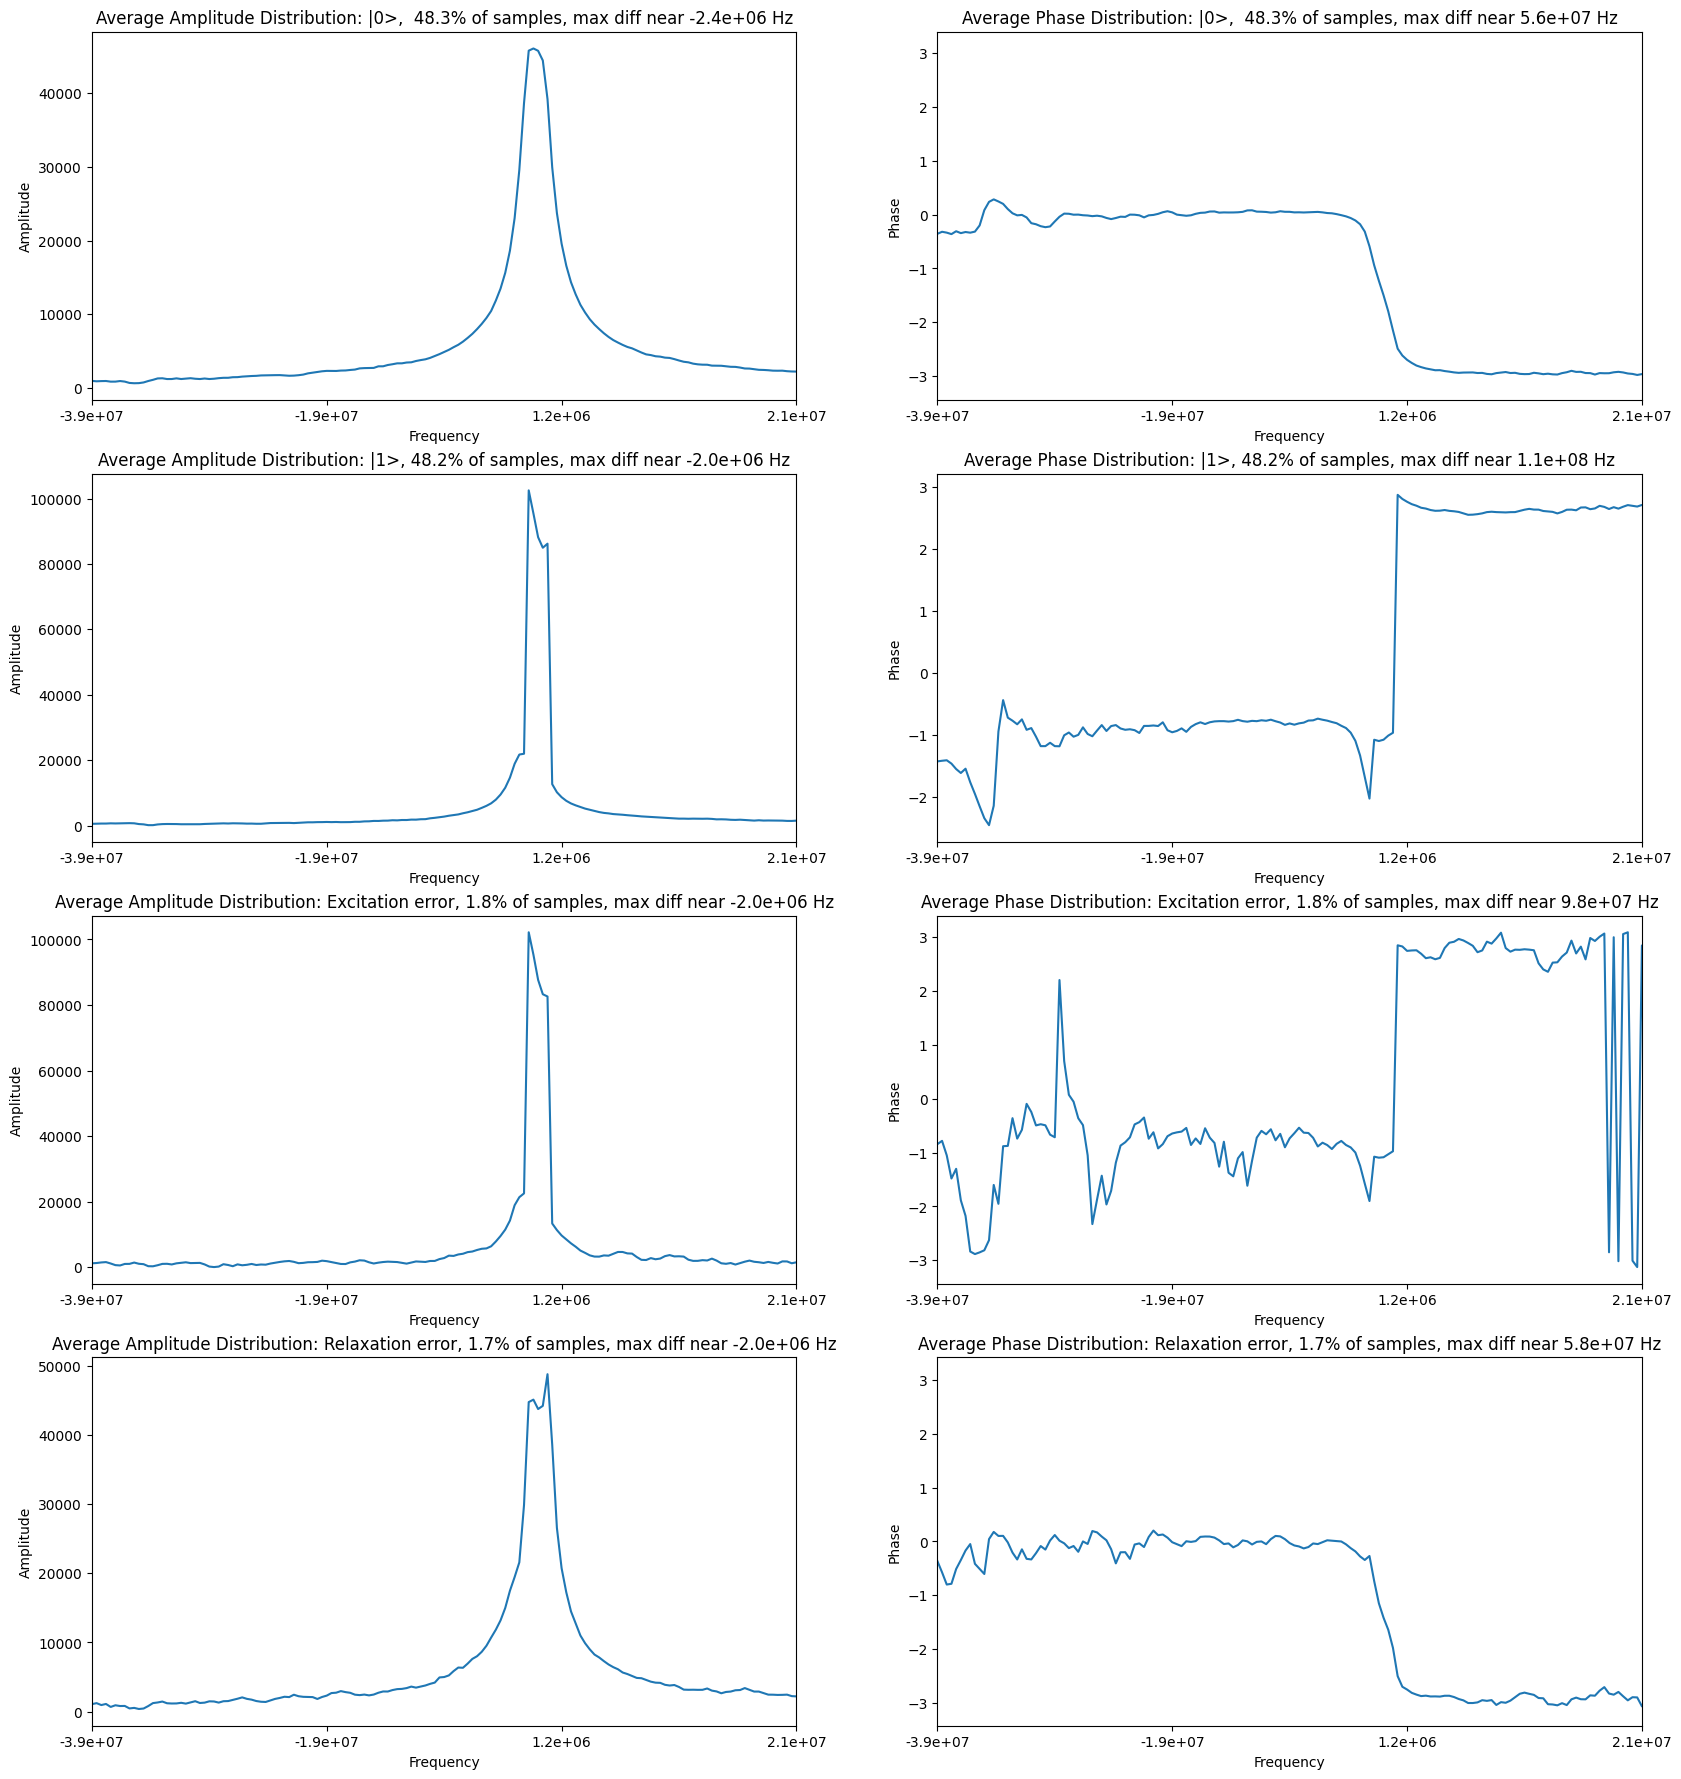

In [43]:
fig, axes = plt.subplots(4, 2, figsize = (20, 22))

for label in labels:
    label_idx = np.where(y_thresh==label)[0]
    label_legend = label_legends[label]
    X_fft_label_mean = np.mean(X_fft_smoothed[label_idx], axis=0)

    X_amp_label_mean = np.abs(X_fft_label_mean)
    X_amp_label_mean_diff = np.diff(X_amp_label_mean)
    max_amp_diff_idx = np.where(X_amp_label_mean_diff==max(X_amp_label_mean_diff))[0]
    X_amp_label_mean_diff_zoomed = X_amp_label_mean_diff[int(max_amp_diff_idx-ran):int(max_amp_diff_idx+ran)]
    axes[label, 0].plot(X_amp_label_mean[int(idx_1mhz-ran):int(idx_1mhz+ran)], label = label_legend)
    axes[label, 0].set_xlabel("Frequency")
    axes[label, 0].set_ylabel("Amplitude")
    axes[label, 0].set_xticks(ticks = xticks, labels = xlabels)
    axes[label, 0].set_xlim(xlims)
    axes[label, 0].set_title(f"Average Amplitude Distribution: {label_legends[label]}, max diff near {X_fft_freqs[max_amp_diff_idx][0]:.1e} Hz")

    X_phase_label_mean = np.angle(X_fft_label_mean)
    X_phase_label_mean_diff = np.diff(X_phase_label_mean)
    max_phase_diff_idx = np.where(X_phase_label_mean_diff==max(X_phase_label_mean_diff))[0]
    X_phase_label_mean_diff_zoomed = X_phase_label_mean_diff[int(max_phase_diff_idx-ran):int(max_phase_diff_idx+ran)]
    axes[label, 1].plot(X_phase_label_mean[int(idx_1mhz-ran):int(idx_1mhz+ran)], label = label_legend)
    axes[label, 1].set_xlabel("Frequency")
    axes[label, 1].set_ylabel("Phase")
    axes[label, 1].set_xticks(ticks = xticks, labels = xlabels)
    axes[label, 1].set_xlim(xlims)
    axes[label, 1].set_title(f"Average Phase Distribution: {label_legends[label]}, max diff near {X_fft_freqs[max_phase_diff_idx][0]:.1e} Hz")

In [42]:
X_fft_freqs[max_amp_diff_idx]

array([-2397602.3976024])